In [9]:
import numpy as np
import ephem
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import pandas as pd
import scipy as sp
import scipy.signal as sig

In [112]:
def get_sec(dtime):
    return dtime.hour * 3600 + dtime.minute * 60 + dtime.second
def get_hour(dtime):
    return get_sec(dtime)/3600
def temp2hr(temp):
    return temp*24/100
def smooth(data, Nfilt=101):
    N = len(data)
    fitdat = np.tile(data,3)
    filt = sig.savgol_filter(fitdat, Nfilt, 3)
    out = np.array([max(0,x) for x in filt[N:2*N]])
    return out

In [113]:
file = 'City Stats - Hanover.csv'
data = pd.read_csv(file)

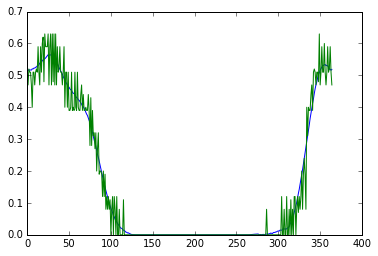

In [117]:
precip_smooth = smooth(data['precip per day'])
snow_smooth = smooth(data['snow per day'], 55)

plt.plot(snow_smooth)
plt.plot(data['snow per day'])

In [118]:
o = ephem.Observer()
o.lat='43.7022'
o.long='-72.2896'
o.elevation=528
o.date='2017-01-01 1:00'

s=ephem.Sun()
s.compute(o)
nr = o.next_rising(s)
offset = get_hour(ephem.localtime(nr))+3 - nr%1*24
nrm = o.next_rising(m)
moff = get_hour(ephem.localtime(nrm))+3 - nrm%1*24


In [119]:
s=ephem.Sun()
m=ephem.Moon()
date = []
sunrise = []
sunset = []
moonrise = []
moonset = []

sunrise_nodst = []
sunset_nodst = []
moonrise_nodst = []
moonset_nodst = []

moonphase = []
for i in range(365):
    s.compute(o)
    m.compute(o)
    date.append(ephem.localtime(o.date))
    srise = get_hour(ephem.localtime(o.next_rising(s)))
    sset = get_hour(ephem.localtime(o.next_setting(s)))
    mrise = get_hour(ephem.localtime(o.next_rising(m)))
    mset = get_hour(ephem.localtime(o.next_setting(m)))

    srise_nodst = (o.next_rising(s)%1*24+offset)%24
    sset_nodst = (o.next_setting(s)%1*24+offset)%24
    mrise_nodst = (o.next_rising(m)%1*24+moff)%24
    mset_nodst = (o.next_setting(m)%1*24+moff)%24

    sunrise.append(srise)
    sunset.append(sset)
    sunrise_nodst.append(srise_nodst)
    sunset_nodst.append(sset_nodst)

    moonrise.append(mrise)
    moonset.append(mset)
    moonrise_nodst.append(mrise_nodst)
    moonset_nodst.append(mset_nodst)

    moonphase.append(m.moon_phase)
    o.date +=1

In [120]:
monthstarts = []
for i in range(1,13):
    monthstarts.append((datetime.date(2017, i, 1) - datetime.date(2017, 1, 1)).days)
monthstarts = np.array(monthstarts)
# print(monthstarts)

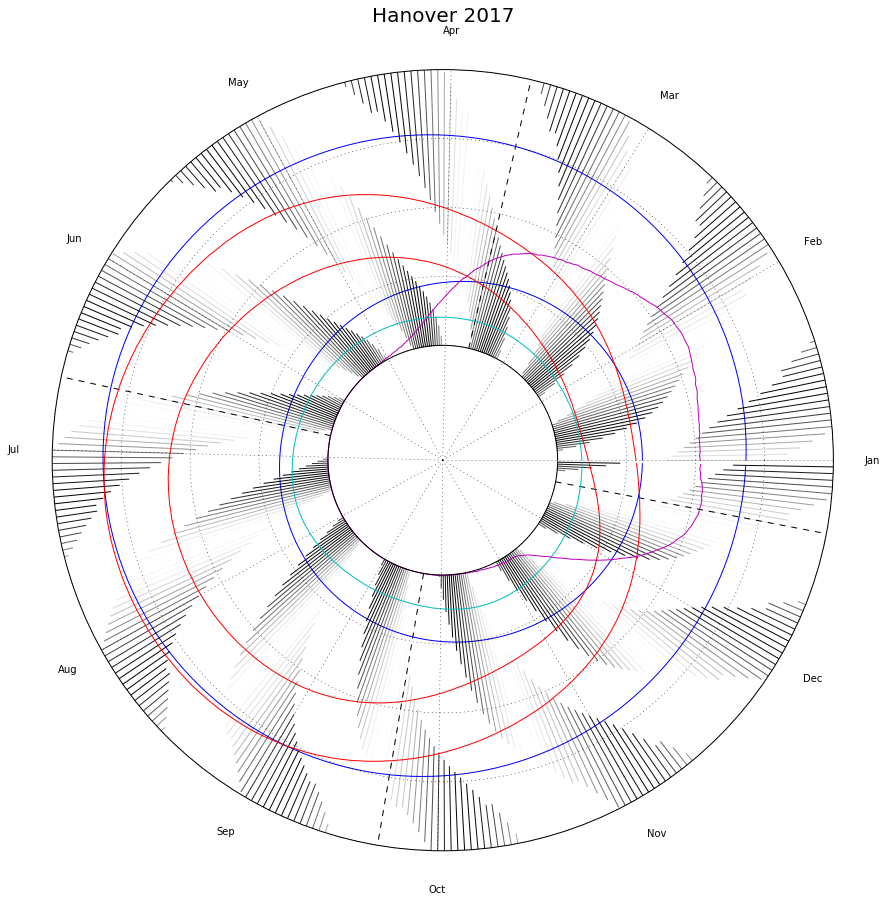

In [122]:
dth = 2*np.pi/len(sunrise)
theta = np.linspace(0, 2 * np.pi-dth, len(sunrise))
msize = 4
roffset = 10
plt.figure(figsize=(14,14))
ax = plt.subplot(111, projection='polar')

# equinox/solstice
seq = (datetime.date(2017,3,20)-datetime.date(2017,1,1)).days
ssol = (datetime.date(2017,6,20)-datetime.date(2017,1,1)).days
feq = (datetime.date(2017,9,22)-datetime.date(2017,1,1)).days
wsol = (datetime.date(2017,12,21)-datetime.date(2017,1,1)).days

ax.plot(np.array([dth,dth])*seq, np.array([0,24])+roffset,'k--')
ax.plot(np.array([dth,dth])*ssol, np.array([0,24])+roffset,'k--')
ax.plot(np.array([dth,dth])*feq, np.array([0,24])+roffset,'k--')
ax.plot(np.array([dth,dth])*wsol, np.array([0,24])+roffset,'k--')

# sunrise and sunset
ax.plot(theta, np.array(sunrise_nodst)+roffset, 'b-')
ax.plot(theta, np.array(sunset_nodst)+roffset, 'b-')

# moonrise/set and phase
for i in range(len(moonrise_nodst)):
    if moonrise_nodst[i] < moonset_nodst[i]:
        start = moonrise_nodst[i]+roffset
        end = moonset_nodst[i]+roffset
        ax.plot([theta[i], theta[i]], [start,end],'k', alpha=moonphase[i])
    else:
        start=0+roffset
        end = moonset_nodst[i]+roffset
        ax.plot([theta[i], theta[i]], [start,end],'k', alpha=moonphase[i])
        start = moonrise_nodst[i]+roffset
        end = 24+roffset
        ax.plot([theta[i], theta[i]], [start,end],'k', alpha=moonphase[i])

# precipitation and temperature
ax.plot(theta, temp2hr(data['high temp'])+roffset,'r-')
ax.plot(theta, temp2hr(data['low temp'])+roffset,'r-')
ax.plot(theta, precip_smooth*24+roffset,'c-')
ax.plot(theta, snow_smooth*24+roffset,'m-')
# ax.plot(theta, moonrise_nodst,'.',markersize=msize)
# ax.plot(theta, moonset_nodst,'.',markersize=msize)

# ax.plot(theta, np.array(moonphase)*2+24.5)
ax.plot(theta, np.ones_like(theta)*roffset,'k-')
ax.set_rmax(24+roffset)
ax.set_xticks(theta[monthstarts])
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

ax.set_yticks([x+roffset for x in [0,6,12,18,24]])
ax.set_yticklabels([])  
# ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
ax.grid(True)

ax.set_title("Hanover 2017", va='bottom', fontsize=20)
plt.savefig('hanover.png')


# plt.show()

In [21]:

#To get U.S. Naval Astronomical Almanac values, use these settings
fred.pressure= 0
fred.horizon = '-0:34'

sunrise=fred.previous_rising(ephem.Sun()) #Sunrise
noon   =fred.next_transit   (ephem.Sun(), start=sunrise) #Solar noon
sunset =fred.next_setting   (ephem.Sun()) #Sunset

#We relocate the horizon to get twilight times
fred.horizon = '-6' #-6=civil twilight, -12=nautical, -18=astronomical
beg_twilight=fred.previous_rising(ephem.Sun(), use_center=True) #Begin civil twilight
end_twilight=fred.next_setting   (ephem.Sun(), use_center=True) #End civil twilight

NameError: name 'fred' is not defined